# Import and process data

In [8]:
file_path = "TWOCLASS.dat"

try:
    with open(file_path, "r") as file:
        content = file.read()
        data = content.split()
        # print(data)
except FileNotFoundError:
    print("File not found!")

# drop the first 6 elements from list 'data'
data = data[6:]

In [9]:
data_processed = []

for i in range(0, len(data), 5):
    data_processed.append([float(data[i]), float(data[i+1]), float(data[i+2]), \
                           float(data[i+3]), int(data[i+4])])

# print length of data
print("Length of data: ", len(data_processed))

Length of data:  200


# Explore the data

In [10]:
import matplotlib.pyplot as plt

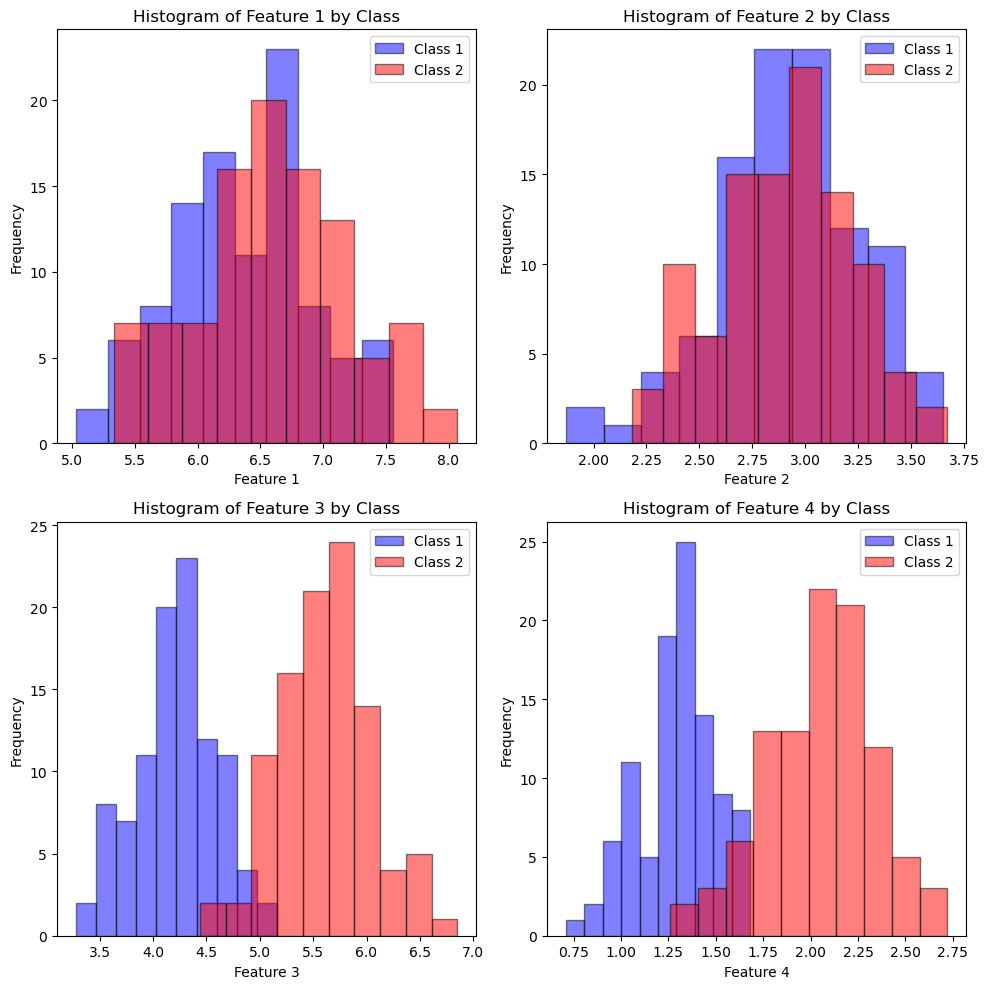

In [11]:
# Separate data by class
class1_data = [sample[:-1] for sample in data_processed if sample[-1] == 1]
class2_data = [sample[:-1] for sample in data_processed if sample[-1] == 2]

# Features (replace these labels with your actual feature names)
feature_labels = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']

# Create a subplot of 2x2 graphs, each with a size of 10x10
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot histograms for each feature
for i in range(len(feature_labels)):
    ax = axs[i // 2, i % 2]  # Get the appropriate subplot
    ax.hist([x[i] for x in class1_data], bins=10, alpha=0.5, color='blue', label='Class 1', edgecolor='black')
    ax.hist([x[i] for x in class2_data], bins=10, alpha=0.5, color='red', label='Class 2', edgecolor='black')
    ax.set_xlabel(feature_labels[i])
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {feature_labels[i]} by Class')
    ax.legend()
    # ax.grid(True)

plt.tight_layout()
plt.show()

# Minimum Risk Bayes Decision Theoretic Classifier
## Using 4 features

In [12]:
# need to use numpy because of the log function and matrix operation, otherwise it will error.
import numpy as np 

print('Using all 4 features')
# Step 1: Estimate Parameters (Mean vectors and Covariance matrices)
def estimate_parameters(data):
    num_features = len(data[0]) - 1  # Exclude the last column (class label)
    num_classes = max(data, key=lambda x: x[-1])[-1]  # Assuming class labels are 1-indexed

    mean_vectors = {i: np.zeros(num_features) for i in range(1, num_classes + 1)}
    covariance_matrices = {i: np.zeros((num_features, num_features)) for i in range(1, num_classes + 1)}
    class_counts = {i: 0 for i in range(1, num_classes + 1)}

    # Calculate the sum of feature values for each class
    for row in data:
        class_label = int(row[-1])
        class_counts[class_label] += 1
        for i in range(num_features):
            mean_vectors[class_label][i] += row[i]

    # Calculate the mean vectors
    for class_label in mean_vectors:
        mean_vectors[class_label] /= class_counts[class_label]

    # Calculate the covariance matrices
    for row in data:
        class_label = int(row[-1])
        x_minus_mean = row[:-1] - mean_vectors[class_label]
        x_minus_mean = x_minus_mean.reshape((-1, 1))  # Convert to column vector
        covariance_matrices[class_label] += np.dot(x_minus_mean, x_minus_mean.T)

    for class_label in covariance_matrices:
        covariance_matrices[class_label] /= (class_counts[class_label] - 1)

    return mean_vectors, covariance_matrices

# Step 2: Minimum Risk Bayes Decision Theoretic Classifier
def multivariate_normal_pdf(x, mean, covariance_matrix):
    # Calculate the multivariate normal probability density function (PDF) for a given test sample 'x'
    # with the given mean and covariance matrix.
    k = len(x)
    coefficient = 1.0 / ((2 * np.pi) ** (k / 2) * np.linalg.det(covariance_matrix))

    # Calculate (x - mean)
    x_minus_mean = x - mean

    # Calculate the inverse of the covariance matrix
    inv_covariance = np.linalg.inv(covariance_matrix)

    # Calculate the Mahalanobis distance squared
    mahalanobis_dist_sq = np.dot(x_minus_mean, np.dot(inv_covariance, x_minus_mean))

    # Calculate the exponent
    exponent = -0.5 * mahalanobis_dist_sq

    return coefficient * np.exp(exponent)

def minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities):
    num_classes = len(mean_vectors)
    risks = [0] * num_classes

    for class_label in range(1, num_classes + 1):
        mean_vector = np.array(mean_vectors[class_label])
        covariance_matrix = np.array(covariance_matrices[class_label])
        
        # Calculate the multivariate normal PDF for the current class
        pdf = multivariate_normal_pdf(test_sample, mean_vector, covariance_matrix)
        
        # Calculate the risk for the current class, which is the negative log-PDF plus the log-prior probability.
        risks[class_label - 1] = -np.log(pdf) + np.log(prior_probabilities[class_label])

    # Choose the class with the minimum risk as the predicted class label.
    predicted_label = np.argmin(risks) + 1
    return predicted_label

# Step 3: 10% Cross Validation
def cross_validation(data):
    num_samples_per_class = len(data) // 2
    fold_size = num_samples_per_class // 10  # Each fold will have 10 samples per class
    total_samples = len(data)
    total_misclassifications = 0
    predicted_labels = []  # List to store the predicted labels for all test samples

    for i in range(10):
        start_idx_class1 = i * fold_size
        end_idx_class1 = (i + 1) * fold_size
        start_idx_class2 = num_samples_per_class + start_idx_class1
        end_idx_class2 = num_samples_per_class + end_idx_class1

        test_set = data[start_idx_class1:end_idx_class1] + data[start_idx_class2:end_idx_class2]
        train_set = data[:start_idx_class1] + data[end_idx_class1:start_idx_class2] + data[end_idx_class2:]

        mean_vectors, covariance_matrices = estimate_parameters(train_set)

        misclassifications = 0
        fold_predicted_labels = []  # List to store the predicted labels for the current fold

        print(f"\nFold {i+1} Results:")
        for sample in test_set:
            test_sample = sample[:-1]  # Exclude the class label from the test sample
            true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            fold_predicted_labels.append(predicted_label)  # Store the predicted label for the current sample

            if predicted_label != true_label:
                misclassifications += 1

            # Display classification information for the current test sample
            print(f"Fold {i+1} - True Label: {true_label}, Predicted Label: {predicted_label}")

        predicted_labels.extend(fold_predicted_labels)  # Add the predicted labels for the current fold to the list
        fold_accuracy = 1 - (misclassifications / (2 * fold_size))
        total_misclassifications += misclassifications

        # Display results for the current fold
        print(f"Accuracy: {fold_accuracy:.2f}")
        print(f"Misclassifications: {misclassifications}/{2 * fold_size}")

        confusion_matrix = [[0, 0], [0, 0]]
        for true_label, predicted_label in zip([1] * fold_size + [2] * fold_size, fold_predicted_labels):
            confusion_matrix[true_label - 1][predicted_label - 1] += 1

        display_results(mean_vectors, covariance_matrices, confusion_matrix)

    overall_accuracy = 1 - (total_misclassifications / total_samples)
    print("\nOverall Results:")
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Overall Misclassifications: {total_misclassifications}/{total_samples}")

    avg_accuracy = 1 - (total_misclassifications / total_samples)
    return avg_accuracy, predicted_labels

# Step 4: Display Results (Mean vectors, Covariance matrices, Confusion matrix, Error estimates, Classification information)
def display_results(mean_vectors, covariance_matrices, confusion_matrix):
    print("Mean Vectors:")
    for class_label, mean_vector in mean_vectors.items():
        print(f"Class {class_label}: {mean_vector}")

    print("\nCovariance Matrices:")
    for class_label, covariance_matrix in covariance_matrices.items():
        print(f"Class {class_label}:")
        for row in covariance_matrix:
            print(row)

    print("\nConfusion Matrix:")
    for row in confusion_matrix:
        print(row)

    total_samples = sum(sum(row) for row in confusion_matrix)
    correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
    error_rate = (total_samples - correct_predictions) / total_samples
    print(f"\nError Rate: {error_rate:.2f}")
    print('\n----------------------------------------')

# Step 5: Main code
# Example data
data = data_processed

# Assuming equal prior probabilities for each class (not hard-coded)
num_classes = max(data, key=lambda x: x[-1])[-1]
prior_probabilities = {i: 1 / num_classes for i in range(1, num_classes + 1)}

# Perform cross-validation and display the results
avg_accuracy, predicted_labels = cross_validation(data)
print(f"\nAverage Accuracy: {avg_accuracy:.2f}")

# Estimate mean vectors and covariance matrices using the entire data
mean_vectors, covariance_matrices = estimate_parameters(data)

# Calculate confusion matrix using the entire data
confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for sample in data:
    true_label = int(sample[-1])
    test_sample = sample[:-1]
    predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
    confusion_matrix[true_label - 1][predicted_label - 1] += 1

print("\nOverall Results:")
print("Mean Vectors:")
for class_label, mean_vector in mean_vectors.items():
    print(f"Class {class_label}: {mean_vector}")

print("\nCovariance Matrices:")
for class_label, covariance_matrix in covariance_matrices.items():
    print(f"Class {class_label}:")
    for row in covariance_matrix:
        print(row)

print("\nConfusion Matrix:")
for row in confusion_matrix:
    print(row)

total_samples = sum(sum(row) for row in confusion_matrix)
correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
error_rate = (total_samples - correct_predictions) / total_samples
print(f"\nError Rate: {error_rate:.2f}")

Using all 4 features

Fold 1 Results:
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Accuracy: 1.00
Misclassifications: 0/20
Mean Vectors:
Class 1: [6.381      2.914      4.23811111 1.301

## Using features 1 & 2 

In [13]:
import numpy as np

print('Using features 1 and 2')
# Step 1: Estimate Parameters (Mean vectors and Covariance matrices)
def estimate_parameters(data):
    num_features = 2  # Considering only features 1 and 2
    num_classes = max(data, key=lambda x: x[-1])[-1]  # Assuming class labels are 1-indexed

    mean_vectors = {i: np.zeros(num_features) for i in range(1, num_classes + 1)}
    covariance_matrices = {i: np.zeros((num_features, num_features)) for i in range(1, num_classes + 1)}
    class_counts = {i: 0 for i in range(1, num_classes + 1)}

    # Calculate the sum of feature values for each class
    for row in data:
        class_label = int(row[-1])
        class_counts[class_label] += 1
        for i in range(num_features):
            mean_vectors[class_label][i] += row[i]

    # Calculate the mean vectors
    for class_label in mean_vectors:
        mean_vectors[class_label] /= class_counts[class_label]

    # Calculate the covariance matrices
    for row in data:
        class_label = int(row[-1])
        x_minus_mean = row[:num_features] - mean_vectors[class_label]
        x_minus_mean = x_minus_mean.reshape((-1, 1))  # Convert to column vector
        covariance_matrices[class_label] += np.dot(x_minus_mean, x_minus_mean.T)

    for class_label in covariance_matrices:
        covariance_matrices[class_label] /= (class_counts[class_label] - 1)

    return mean_vectors, covariance_matrices

# Step 2: Minimum Risk Bayes Decision Theoretic Classifier
def multivariate_normal_pdf(x, mean, covariance_matrix):
    # Calculate the multivariate normal probability density function (PDF) for a given test sample 'x'
    # with the given mean and covariance matrix.
    k = len(x)
    coefficient = 1.0 / ((2 * np.pi) ** (k / 2) * np.linalg.det(covariance_matrix))

    # Calculate (x - mean)
    x_minus_mean = x - mean

    # Calculate the inverse of the covariance matrix
    inv_covariance = np.linalg.inv(covariance_matrix)

    # Calculate the Mahalanobis distance squared
    mahalanobis_dist_sq = np.dot(x_minus_mean, np.dot(inv_covariance, x_minus_mean))

    # Calculate the exponent
    exponent = -0.5 * mahalanobis_dist_sq

    return coefficient * np.exp(exponent)

def minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities):
    num_classes = len(mean_vectors)
    risks = [0] * num_classes

    for class_label in range(1, num_classes + 1):
        mean_vector = np.array(mean_vectors[class_label])
        covariance_matrix = np.array(covariance_matrices[class_label])

        # Extract only the first two features from the test sample
        test_sample_2d = test_sample[:2]

        # Calculate the multivariate normal PDF for the current class
        pdf = multivariate_normal_pdf(test_sample_2d, mean_vector[:2], covariance_matrix[:2, :2])

        # Calculate the risk for the current class, which is the negative log-PDF plus the log-prior probability.
        risks[class_label - 1] = -np.log(pdf) + np.log(prior_probabilities[class_label])

    # Choose the class with the minimum risk as the predicted class label.
    predicted_label = np.argmin(risks) + 1
    return predicted_label

# Step 3: 10% Cross Validation
def cross_validation(data):
    num_samples_per_class = len(data) // 2
    fold_size = num_samples_per_class // 10  # Each fold will have 10 samples per class
    total_samples = len(data)
    total_misclassifications = 0
    predicted_labels = []  # List to store the predicted labels for all test samples

    for i in range(10):
        start_idx_class1 = i * fold_size
        end_idx_class1 = (i + 1) * fold_size
        start_idx_class2 = num_samples_per_class + start_idx_class1
        end_idx_class2 = num_samples_per_class + end_idx_class1

        test_set = data[start_idx_class1:end_idx_class1] + data[start_idx_class2:end_idx_class2]
        train_set = data[:start_idx_class1] + data[end_idx_class1:start_idx_class2] + data[end_idx_class2:]

        mean_vectors, covariance_matrices = estimate_parameters(train_set)

        misclassifications = 0
        fold_predicted_labels = []  # List to store the predicted labels for the current fold

        print(f"\nFold {i+1} Results:")
        for sample in test_set:
            test_sample = sample[:-1]  # Exclude the class label from the test sample
            true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            fold_predicted_labels.append(predicted_label)  # Store the predicted label for the current sample

            if predicted_label != true_label:
                misclassifications += 1

            # Display classification information for the current test sample
            print(f"Fold {i+1} - True Label: {true_label}, Predicted Label: {predicted_label}")

        predicted_labels.extend(fold_predicted_labels)  # Add the predicted labels for the current fold to the list
        fold_accuracy = 1 - (misclassifications / (2 * fold_size))
        total_misclassifications += misclassifications

        # Display results for the current fold
        print(f"Accuracy: {fold_accuracy:.2f}")
        print(f"Misclassifications: {misclassifications}/{2 * fold_size}")

        confusion_matrix = [[0, 0], [0, 0]]
        for true_label, predicted_label in zip([1] * fold_size + [2] * fold_size, fold_predicted_labels):
            confusion_matrix[true_label - 1][predicted_label - 1] += 1

        display_results(mean_vectors, covariance_matrices, confusion_matrix)

    overall_accuracy = 1 - (total_misclassifications / total_samples)
    print("\nOverall Results:")
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Overall Misclassifications: {total_misclassifications}/{total_samples}")

    avg_accuracy = 1 - (total_misclassifications / total_samples)
    return avg_accuracy, predicted_labels

# Step 4: Display Results (Mean vectors, Covariance matrices, Confusion matrix, Error estimates, Classification information)
def display_results(mean_vectors, covariance_matrices, confusion_matrix):
    print("Mean Vectors:")
    for class_label, mean_vector in mean_vectors.items():
        print(f"Class {class_label}: {mean_vector}")

    print("\nCovariance Matrices:")
    for class_label, covariance_matrix in covariance_matrices.items():
        print(f"Class {class_label}:")
        for row in covariance_matrix:
            print(row)

    print("\nConfusion Matrix:")
    for row in confusion_matrix:
        print(row)

    total_samples = sum(sum(row) for row in confusion_matrix)
    correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
    error_rate = (total_samples - correct_predictions) / total_samples
    print(f"\nError Rate: {error_rate:.2f}")
    print('\n----------------------------------------')

# Step 5: Main code
data = data_processed

# Assuming equal prior probabilities for each class (not hard-coded)
num_classes = max(data, key=lambda x: x[-1])[-1]
prior_probabilities = {i: 1 / num_classes for i in range(1, num_classes + 1)}

# Perform cross-validation and display the results
avg_accuracy, predicted_labels = cross_validation(data)
print(f"\nAverage Accuracy: {avg_accuracy:.2f}")

# Estimate mean vectors and covariance matrices using the entire data
mean_vectors, covariance_matrices = estimate_parameters(data)

# Calculate confusion matrix using the entire data
confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for sample in data:
    true_label = int(sample[-1])
    test_sample = sample[:-1]
    predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
    confusion_matrix[true_label - 1][predicted_label - 1] += 1

print("\nOverall Results:")
print("Mean Vectors:")
for class_label, mean_vector in mean_vectors.items():
    print(f"Class {class_label}: {mean_vector}")

print("\nCovariance Matrices:")
for class_label, covariance_matrix in covariance_matrices.items():
    print(f"Class {class_label}:")
    for row in covariance_matrix:
        print(row)

print("\nConfusion Matrix:")
for row in confusion_matrix:
    print(row)

total_samples = sum(sum(row) for row in confusion_matrix)
correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
error_rate = (total_samples - correct_predictions) / total_samples
print(f"\nError Rate: {error_rate:.2f}")


Using features 1 and 2

Fold 1 Results:
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 2
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Accuracy: 0.60
Misclassifications: 8/20
Mean Vectors:
Class 1: [6.381 2.914]
Class 2: [6.61466667 2.